<a href="https://colab.research.google.com/github/sunandhini96/ERA_S7/blob/main/ERA1S7Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2 :
Dataset : MNIST
Applied : for model_1 + dropout + image augmentation
(to improve performance -> dropout , image augmentation -> improving the training)

In [15]:
!git clone "https://github.com/sunandhini96/ERA_S7.git"

Cloning into 'ERA_S7'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 169.67 KiB | 247.00 KiB/s, done.
Resolving deltas: 100% (12/12), done.


In [16]:
cd /content/ERA_S7

/content/ERA_S7


In [17]:
pwd

'/content/ERA_S7'

In [18]:
!python model.py

In [19]:
from model import *

# Import Libraries

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [20]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [21]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [22]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Summary of the model

In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
from torch.optim.lr_scheduler import StepLR

model =  Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.1526951789855957 Batch_id=937 Accuracy=89.72: 100%|██████████| 938/938 [00:43<00:00, 21.71it/s]



Test set: Average loss: 0.0675, Accuracy: 9802/10000 (98.02%)

EPOCH: 1


Loss=0.06809452921152115 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:42<00:00, 22.03it/s]



Test set: Average loss: 0.0519, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.01710532046854496 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:43<00:00, 21.75it/s]



Test set: Average loss: 0.0411, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.014946089126169682 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:44<00:00, 21.27it/s]



Test set: Average loss: 0.0348, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.025842370465397835 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:43<00:00, 21.33it/s]



Test set: Average loss: 0.0320, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.07382788509130478 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:43<00:00, 21.73it/s]



Test set: Average loss: 0.0350, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.006195953115820885 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:43<00:00, 21.51it/s]



Test set: Average loss: 0.0268, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.01763985864818096 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:44<00:00, 21.29it/s]



Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.14123041927814484 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:42<00:00, 21.87it/s]



Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.007287764456123114 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]



Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.003910791128873825 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:49<00:00, 18.85it/s]



Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.021080872043967247 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:46<00:00, 20.35it/s]



Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.01667523756623268 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:43<00:00, 21.52it/s]



Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.009174858219921589 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:45<00:00, 20.58it/s]



Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.007584875915199518 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:43<00:00, 21.78it/s]



Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

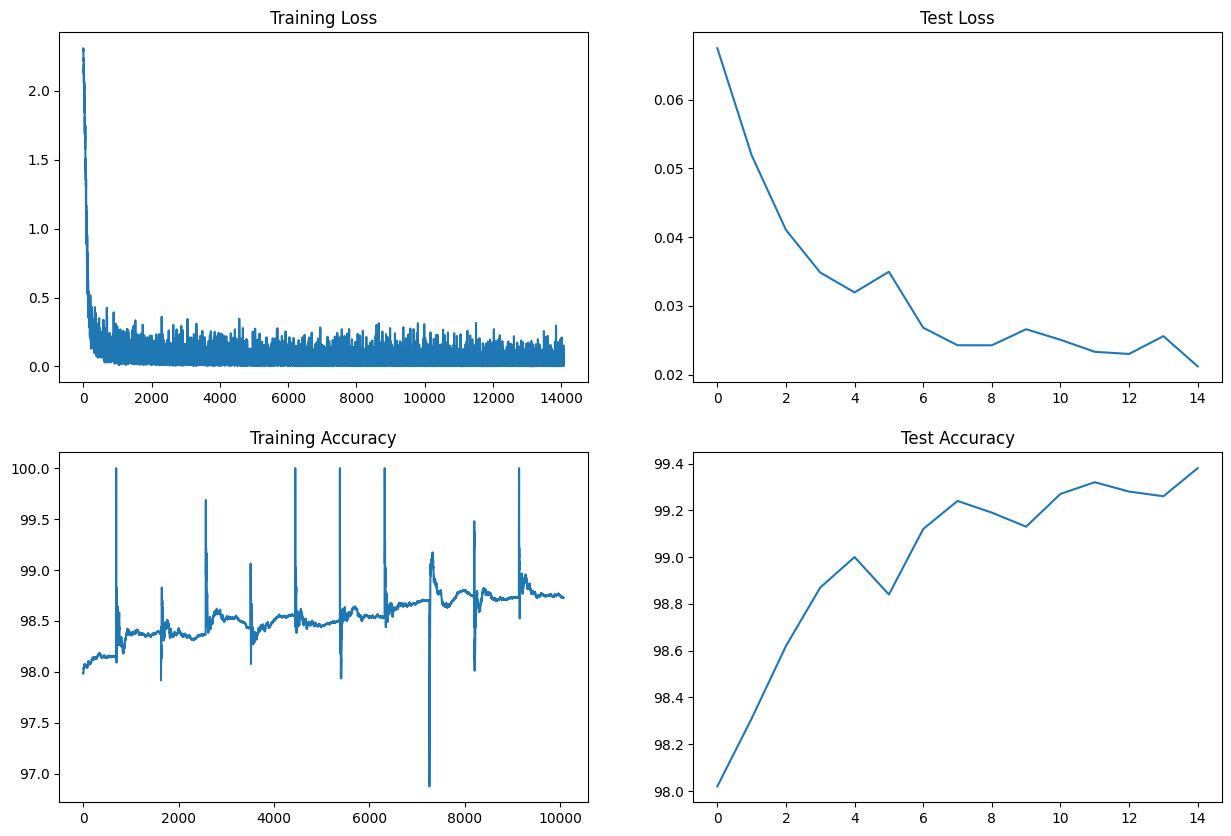

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
-> We added dropout and image augmentation to improve performance and for better training. To avoid overfitting we applied dropout.
## Results:
-> Parameters: 7.7k

-> Best Train Accuracy: 98.75

-> Best Test Accuracy: 99.38

## Analysis:
-> model is training accuracy is not high as model 1 because we applied image augmentation. We are getting best test accuracy around 99.38 % but still we are not getting our target accuracy 99.4 % within 15 epochs.  